In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm 

In [2]:
class Planeta:
    
    def __init__(self, e, a, t):
        
        self.t = t
        self.dt = t[1] - t[0] # Paso del tiempo
        
        self.e = e # Excentricidad
        self.a_ = a # Semi-eje mayor
        
        self.G = 4*np.pi**2 # Unidades gaussianas
        
        self.r = np.zeros(3)
        self.v = np.zeros_like(self.r)
        self.a = np.zeros_like(self.r)
        
        self.r[0] = self.a_*(1-self.e)
        self.v[1] = np.sqrt( self.G*(1+self.e)/(self.a_*(1.-self.e)) )
        
        self.R = np.zeros((len(t),len(self.r)))
        self.V = np.zeros_like(self.R)
        
        # El valor del pasado
        self.rp = self.r
        self.vp = self.v
        
    def GetAceleration(self):
        
        d = np.linalg.norm(self.r)
        self.a = -self.G/d**3*self.r
        
        
    def Evolution(self,i):
        
        self.SetPosition(i)
        self.SetVelocity(i)
        self.GetAceleration()
        
        if i==0:
            self.r = self.rp + self.v*self.dt
        else:
            
            # rp pasado, r presente rf futuro

            self.rf = self.r + self.v*self.dt + 0.5*self.a*self.dt**2
            #self.rf = 2*self.r - self.rp + self.a*self.dt**2

            #vf = (self.rf - self.rp)/(2*self.dt)
            #posf = self.rf + vf*self.dt + 0.5*self.a*self.dt**2
            df = np.linalg.norm(self.rf)
            af = -self.G/df**3*self.rf

            self.v = self.vp + 0.5*(af + self.a)*self.dt
            #self.v = (self.rf - self.rp)/(2*self.dt)
            
            self.rp = self.r
            self.r = self.rf
            self.vp = self.v
    
    def SetPosition(self,i):
        self.R[i] = self.r
        
    def SetVelocity(self,i):
        self.V[i] = self.v
    
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
    
    def GetPerihelio(self):
        
        Dist = np.linalg.norm(self.R,axis=1)
        
        pos = []
        time = []
        
        for i in range(1,len(Dist)-1):
            if Dist[i] < Dist[i-1] and Dist[i] < Dist[i+1]:
                pos.append(self.R[i])
                time.append(self.t[i])
            
        return pos, time

In [3]:
def GetPlanetas(t):
    
    Mercurio = Planeta(0.205630,0.387098,t)
    #Venus = Planeta(0.0067,0.7233,t)
    #Tierra = Planeta(0.01671,1.,t)
    
    return [Mercurio]

In [5]:
dt = 1*10**(-6)
tmax = 2.5
t = np.arange(0.,tmax,dt)
Planetas = GetPlanetas(t)

In [6]:
def RunSimulation(t,Planetas):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        #print(it)
        for i in range(len(Planetas)):
            Planetas[i].Evolution(it)
            # Aca debes agregar la interaccion con la pared
            
            
    return Planetas

In [7]:
Planetas = RunSimulation(t,Planetas)

Running simulation: 100%|██████████| 2500000/2500000 [01:09<00:00, 36012.28 Steps/s]


[65304.01711258 33451.60181196 22923.0078559  17592.07426149
 14446.81987854 12305.565078   10814.16926239  9662.31049535
  8766.42081556]


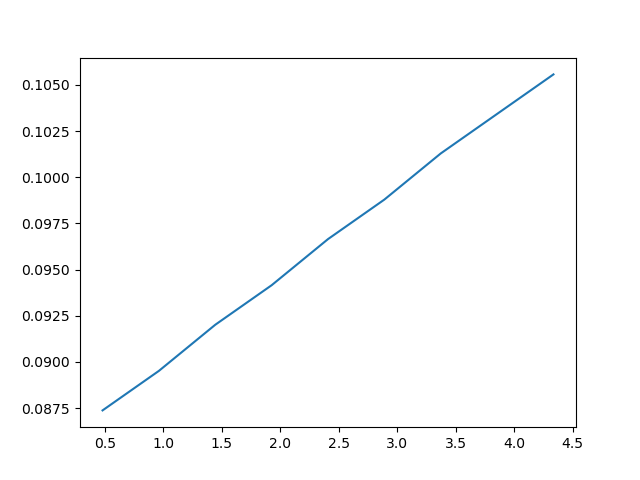

In [87]:
peri, anos = Planetas[0].GetPerihelio()


ang = [0]

for i in range(1, len(peri)):
    r1 = peri[i-1]/(np.linalg.norm(peri[i-1]))
    r2 = peri[i]/(np.linalg.norm(peri[i]))     
    theta += np.arccos(np.clip(np.dot(r1, r2), -1.0, 1.0))
    ang.append(theta)


time = np.array(anos)
time = time - np.full(len(time), anos[0])

time = np.array(time[1:10])
ang = np.array(ang[1:10])


arc = ang*3600*180/np.pi
cent = time/100

v = arc/cent


figura = plt.figure()
axis = figura.add_subplot(111)

axis.plot(2*(time), 2*ang*180/np.pi)

print(v)




In [67]:
scale = 20
t1 = t[::scale]

In [58]:
#plt.plot(Planetas[0].GetPosition()[:,0],Planetas[0].GetPosition()[:,1])

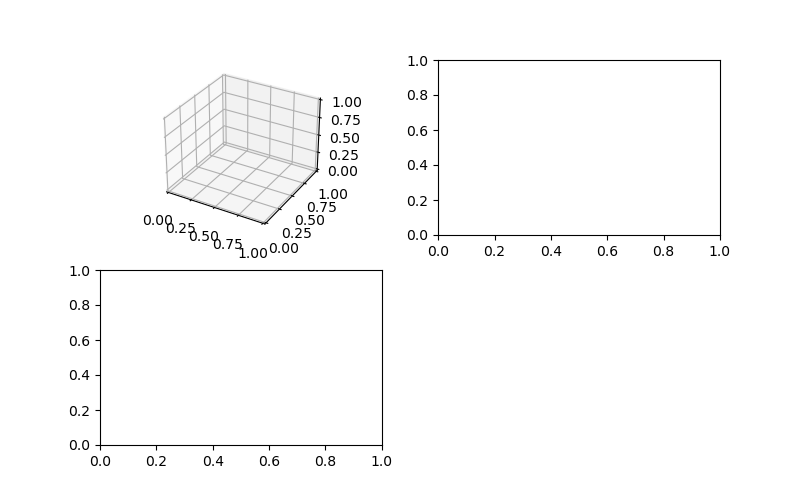

In [137]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(221,projection='3d')
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)

colors=['r','k','b']

def init():
    
    ax.clear()
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    
    ax1.clear()
    ax1.set_xlim(-1,1)
    ax1.set_ylim(-1,1) 
    
    ax2.clear()
    ax2.set_xlim(-2,2)
    ax2.set_ylim(-2,2) 
    
def Update(i):
    
    init()
    
    for j, p in enumerate(Planetas):
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        z = p.GetPosition(scale)[i,2]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        vz = p.GetVelocity(scale)[i,2]
    
        ax.scatter(0,0,0,s=200,color='y')
        ax.quiver(x,y,z,vx,vy,vz,color=colors[j],length=0.03)
        
        ax.scatter(x,y,z,color=colors[j])
        
        circle = plt.Circle((x,y),0.1,color=colors[j],fill=True)
        ax1.add_patch(circle)
    
    # Mercurio visto desde tierra
    #Mx = Planetas[0].GetPosition(scale)[:i,0] - Planetas[2].GetPosition(scale)[:i,0]
    #My = Planetas[0].GetPosition(scale)[:i,1] - Planetas[2].GetPosition(scale)[:i,1]
    
    # Venus visto desde tierra
    #Vx = Planetas[1].GetPosition(scale)[:i,0] - Planetas[2].GetPosition(scale)[:i,0]
    #Vy = Planetas[1].GetPosition(scale)[:i,1] - Planetas[2].GetPosition(scale)[:i,1]
    
    #ax2.scatter(Mx,My,marker='.',label='Mercurio')
    #ax2.scatter(Vx,Vy,marker='.',label='Venus')
    
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)